In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
def load_dataset(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1309,), (0.3083,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1309,), (0.3083,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)


In [4]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        
        self.layer1 = nn.Conv2d(1, 6, 5)
        self.layer2 = nn.Conv2d(6, 16, 5)
        self.fc_layer1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.layer1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer2(x)), 2)
       
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))

        x = self.fc_layer3(x)
        return x

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 32, 5)
        self.layer2 = nn.Conv2d(32, 32, 5)
        self.layer3 = nn.Conv2d(32, 64, 5)
        self.fc_layer1 = nn.Linear(1024, 256)
        self.fc_layer2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(F.max_pool2d(self.layer2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.layer3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc_layer1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc_layer2(x)
        return F.log_softmax(x, dim=1)

In [6]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_dataset(train_batch_size, test_batch_size)


In [7]:
def train_model(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    correct_predictions = 0
    total_loss = 0
    batch_count = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        batch_count += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.data

        predictions = np.argmax(output.data, axis=1)
        total_samples += target.size(0)
        correct_predictions += (predictions == target).sum().item()
        accuracy = 100.0 * correct_predictions / total_samples

        if batch_idx % log_interval == 0:
            print('  Train_set, epoch # {} [{}/{}]\tLoss: {:.7f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.data))
            print("  TRAINING ACCURACY: ", round(accuracy, 2))
    average_loss = total_loss / batch_count
    return average_loss, round(accuracy, 2)

In [8]:
def evaluate_model(model, epoch, test_loader):
    model.eval()
    average_loss = 0
    correct_predictions = 0
    
    loss_function = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        average_loss += loss_function(output, target).data

        predictions = np.argmax(output.data, axis=1)
        correct_predictions += np.equal(predictions, target.data).sum()

    average_loss /= len(test_loader.dataset)
    print('\n ##### TEST SET -- EPOCH # {} , AVERAGE LOSS --> {:.7f}, ACCURACY, % {}/{} ({:.2f}%)\n'.format(epoch,
        average_loss, correct_predictions, len(test_loader.dataset),
        100. * correct_predictions / len(test_loader.dataset)))

In [9]:

torch.manual_seed(1)
model_le_net = CustomLeNet()

learning_rate = 0.01
momentum = 0.5
optimizer_le_net = optim.SGD(model_le_net.parameters(), lr=learning_rate, momentum=momentum)
le_net_loss_history = []
le_net_acc_history = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs):
    loss, acc = train_model(model_le_net, optimizer_le_net, epoch, train_loader, log_interval)
    le_net_loss_history.append(loss)
    le_net_acc_history.append(acc)
    evaluate_model(model_le_net, epoch, test_loader)

  Train_set, epoch # 1 [0/60000]	Loss: 2.3222549
  TRAINING ACCURACY:  10.94
  Train_set, epoch # 1 [12800/60000]	Loss: 0.3892025
  TRAINING ACCURACY:  46.47
  Train_set, epoch # 1 [25600/60000]	Loss: 0.3169593
  TRAINING ACCURACY:  66.1
  Train_set, epoch # 1 [38400/60000]	Loss: 0.2633241
  TRAINING ACCURACY:  74.56
  Train_set, epoch # 1 [51200/60000]	Loss: 0.2470221
  TRAINING ACCURACY:  79.34


/home/tvaspar/.local/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 ##### TEST SET -- EPOCH # 1 , AVERAGE LOSS --> 0.1383734, ACCURACY, % 9592/10000 (95.92%)

  Train_set, epoch # 2 [0/60000]	Loss: 0.1574591
  TRAINING ACCURACY:  95.31
  Train_set, epoch # 2 [12800/60000]	Loss: 0.1327443
  TRAINING ACCURACY:  95.29
  Train_set, epoch # 2 [25600/60000]	Loss: 0.3698585
  TRAINING ACCURACY:  95.63
  Train_set, epoch # 2 [38400/60000]	Loss: 0.0958299
  TRAINING ACCURACY:  95.89
  Train_set, epoch # 2 [51200/60000]	Loss: 0.1107995
  TRAINING ACCURACY:  96.13

 ##### TEST SET -- EPOCH # 2 , AVERAGE LOSS --> 0.0774230, ACCURACY, % 9759/10000 (97.59%)

  Train_set, epoch # 3 [0/60000]	Loss: 0.0259789
  TRAINING ACCURACY:  100.0
  Train_set, epoch # 3 [12800/60000]	Loss: 0.0789586
  TRAINING ACCURACY:  97.36
  Train_set, epoch # 3 [25600/60000]	Loss: 0.0472774
  TRAINING ACCURACY:  97.33
  Train_set, epoch # 3 [38400/60000]	Loss: 0.0368181
  TRAINING ACCURACY:  97.41
  Train_set, epoch # 3 [51200/60000]	Loss: 0.0720241
  TRAINING ACCURACY:  97.44

 ##### TEST

In [10]:
torch.manual_seed(1)

model_cnn = CustomCNN()

optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=momentum)
cnn_loss_history = []
cnn_acc_history = []

epochs = 10
log_interval = 100
for epoch in range(1, epochs):
    loss, acc = train_model(model_cnn, optimizer_cnn, epoch, train_loader, log_interval=log_interval)
    cnn_loss_history.append(loss)
    cnn_acc_history.append(acc)
    evaluate_model(model_cnn, epoch, test_loader)

  Train_set, epoch # 1 [0/60000]	Loss: 2.3151467
  TRAINING ACCURACY:  6.25
  Train_set, epoch # 1 [6400/60000]	Loss: 1.5455017
  TRAINING ACCURACY:  24.72
  Train_set, epoch # 1 [12800/60000]	Loss: 0.9440089
  TRAINING ACCURACY:  45.79
  Train_set, epoch # 1 [19200/60000]	Loss: 0.4023380
  TRAINING ACCURACY:  57.52
  Train_set, epoch # 1 [25600/60000]	Loss: 0.4175568
  TRAINING ACCURACY:  64.53
  Train_set, epoch # 1 [32000/60000]	Loss: 0.2901089
  TRAINING ACCURACY:  69.06
  Train_set, epoch # 1 [38400/60000]	Loss: 0.3916486
  TRAINING ACCURACY:  72.34
  Train_set, epoch # 1 [44800/60000]	Loss: 0.3106150
  TRAINING ACCURACY:  74.97
  Train_set, epoch # 1 [51200/60000]	Loss: 0.2847349
  TRAINING ACCURACY:  76.97
  Train_set, epoch # 1 [57600/60000]	Loss: 0.4905190
  TRAINING ACCURACY:  78.65

 ##### TEST SET -- EPOCH # 1 , AVERAGE LOSS --> 0.1214551, ACCURACY, % 9628/10000 (96.28%)

  Train_set, epoch # 2 [0/60000]	Loss: 0.2918154
  TRAINING ACCURACY:  92.19
  Train_set, epoch # 2 [64

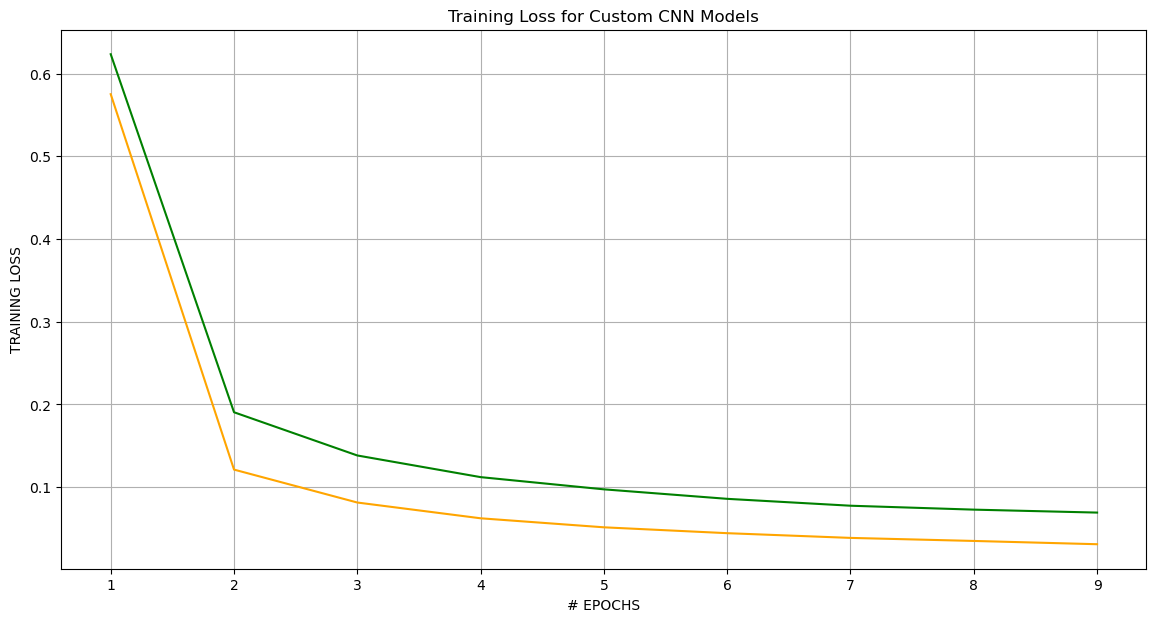

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 10, 1), le_net_loss_history, color="orange")  # Changed color to orange
plt.plot(np.arange(1, 10, 1), cnn_loss_history, color="green")  # Changed color to green
plt.xlabel("# EPOCHS")
plt.ylabel("TRAINING LOSS")
plt.title("Training Loss for Custom CNN Models")
plt.grid(True)


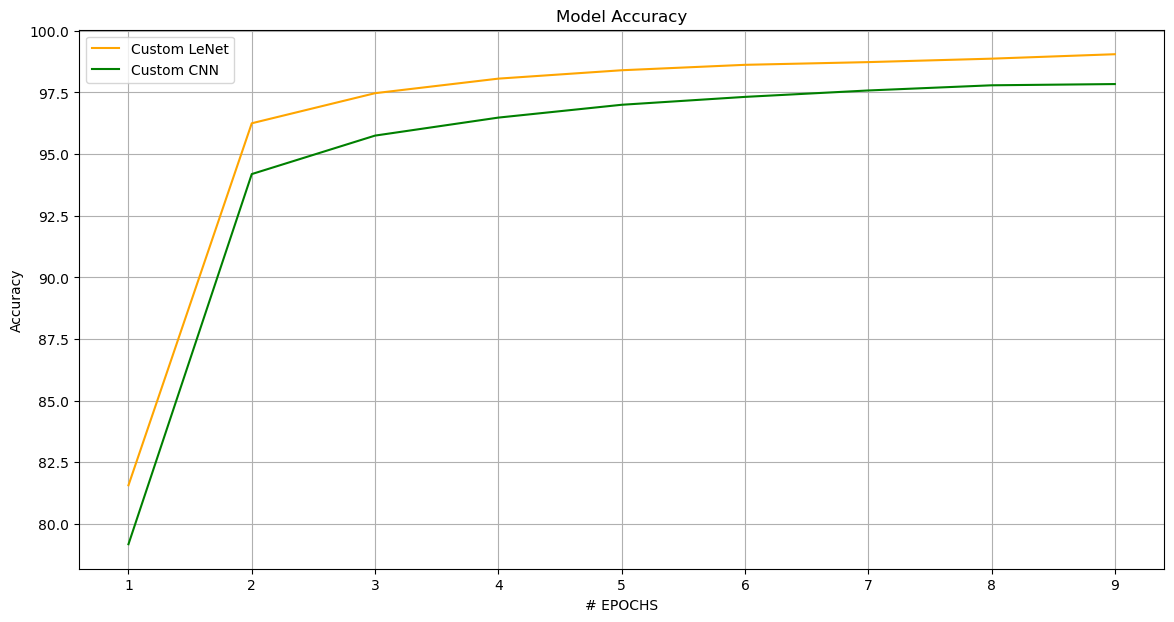

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 10, 1), le_net_acc_history, color="orange")  # Changed color to orange
plt.plot(np.arange(1, 10, 1), cnn_acc_history, color="green")  # Changed color to green
plt.title('Model Accuracy')
plt.legend(['Custom LeNet', 'Custom CNN'])
plt.xlabel('# EPOCHS')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()